In [1]:
% matplotlib inline
from __future__ import division
from __future__ import print_function

from astropy.io import fits
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import numpy as np

from numina.array.display.ximshow import ximshow
from numina.array.display.ximplotxy import ximplotxy

# Reduction of HD209290 (HIP 108782)


## Raw data:

Compressed tar.gz file with 6 images: [ngc7798_files.tgz](http://guaix.fis.ucm.es/~ncl/temp/ngc7798_files.tgz)

```bash
% tar zxvf ngc7798_files.tgz
% ls *.fits
0001005178-20160727-EMIR-TEST0.fits  0001005211-20160727-EMIR-TEST0.fits
0001005189-20160727-EMIR-TEST0.fits  0001005222-20160727-EMIR-TEST0.fits
0001005200-20160727-EMIR-TEST0.fits  0001005233-20160727-EMIR-TEST0.fits
```

The content of these files can be rapidly shown using:

```bash
% dfits 000100*20160727-EMIR-TEST0.fits | fitsort object grism filter exptime date-obs
FILE                               	OBJECT  	GRISM   FILTER EXPTIME   	DATE-OBS              	
0001005178-20160727-EMIR-TEST0.fits	NGC7798 	J       J      119.991601	2016-07-28T04:11:03.88	
0001005189-20160727-EMIR-TEST0.fits	NGC7798 	J       J      119.991601	2016-07-28T04:14:16.98	
0001005200-20160727-EMIR-TEST0.fits	NGC7798 	H       H      119.991601	2016-07-28T04:21:09.38	
0001005211-20160727-EMIR-TEST0.fits	NGC7798 	H       H      119.991601	2016-07-28T04:24:24.59	
0001005222-20160727-EMIR-TEST0.fits	NGC7798 	K       Ksp    119.991601	2016-07-28T04:29:42.10	
0001005233-20160727-EMIR-TEST0.fits	NGC7798 	K       Ksp    119.991601	2016-07-28T04:33:21.57
```

The CSU configuration can be displayed with:
```bash
% pyemir-display_slitlet_arrangement 000100*20160727-EMIR-TEST0.fits
```


## Reduction of the galaxy spectra (A - B)

The following steps are going to be carried out with the grims J + filter J images. For the other settings the steps are similar.

### Subtraction of consecutive images to remove the sky spectrum:

```bash
% numina-imath 0001005189-20160727-EMIR-TEST0.fits - 0001005178-20160727-EMIR-TEST0.fits grismJ_A-B.fits
```

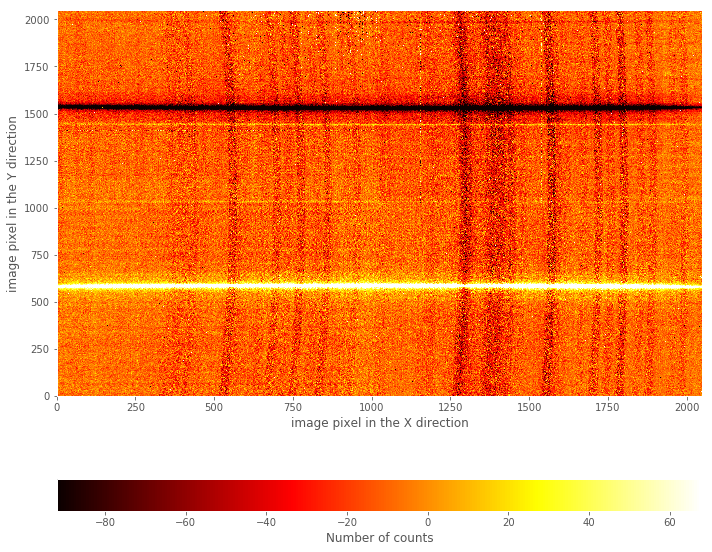

In [3]:
with fits.open('reduction_ngc7798/grismJ_A-B.fits', mode='readonly') as hdulist:
    image_data = hdulist[0].data
    
ximshow(image_data, geometry=None, debugplot=1)

### Apply bad-pixel mask
```bash
% numina-bpm grismJ_A-B.fits --bpm BadPixMask_F.fits --outfile grismJ_A-B_bpm.fits
```

### Overplot of slitlet boundaries

```bash
% pyemir-overplot_boundary_model grismJ_A-B_bpm.fits \
  --fitted_bound_param refined_multislit_param_grism_J_filter_J.json \
  --ds9reg_boundaries ds9_boundaries_grismJ_A-B.reg \
  --ds9reg_frontiers ds9_frontiers_grismJ_A-B.reg
```
![](reduction_ngc7798/images/grismJ_A-B_overplot_boundary1.png)
![](reduction_ngc7798/images/grismJ_A-B_overplot_boundary2.png)

### Flatfield (pixel-to-pixel variation)

```bash
% numina-imath grismJ_A-B_bpm.fits / continuum_ls06_J_J_on-off_flat.fits grismJ_A-B_flat.fits
```

### Rectification and wavelength calibration

```bash
% pyemir-apply_rect_wpoly grismJ_A-B_flat.fits \
  --coef_rect_wpoly coef_rect_wpoly_ls06_grism_J_filter_J_direct_verified.json \
  --ignore_DTUconf \
  --outfile grismJ_A-B_rectwv.fits
```

In [54]:
# read FITS image
with fits.open('reduction_ngc7798/grismJ_A-B_rectwv.fits', mode='readonly') as hdulist:
    image_header = hdulist[0].header
    image_data = hdulist[0].data
    
# image dimensions
naxis2, naxis1 = image_data.shape
print('naxis1, naxis2:', naxis1, naxis2)
    
# read wavelength calibration from header
crpix1 = image_header['crpix1']
crval1 = image_header['crval1']
cdelt1 = image_header['cdelt1']
exptime = image_header['exptime']
print('crpix1, crval1, cdelt1:', crpix1, crval1, cdelt1)
print('exptime:', exptime)

naxis1, naxis2: 3400 2048
crpix1, crval1, cdelt1: 1.0 11220.0 0.7575
exptime: 119.991601


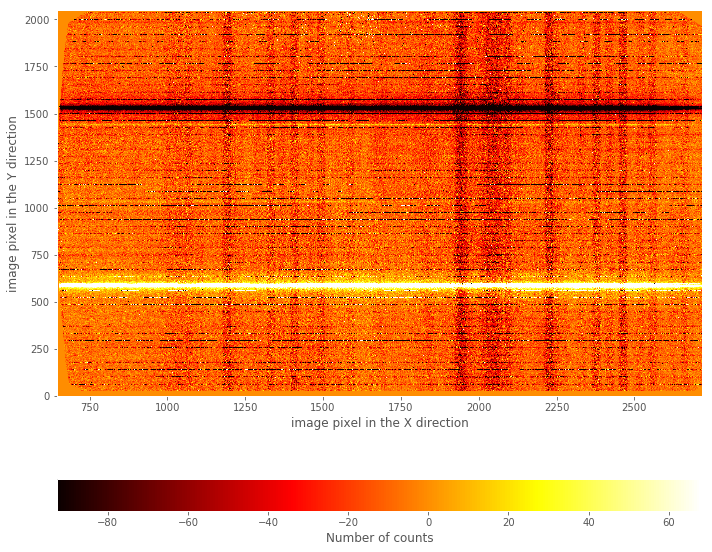

In [7]:
ximshow(image_data, image_bbox=(645,2717,1,2048), geometry=None, debugplot=1)

### Spectrum extraction

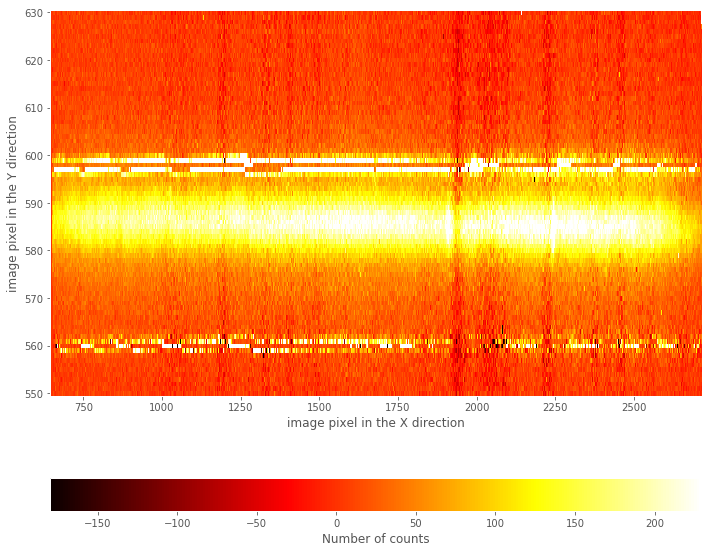

In [8]:
ximshow(image_data, image_bbox=(645,2717,550,630), geometry=None, debugplot=1)

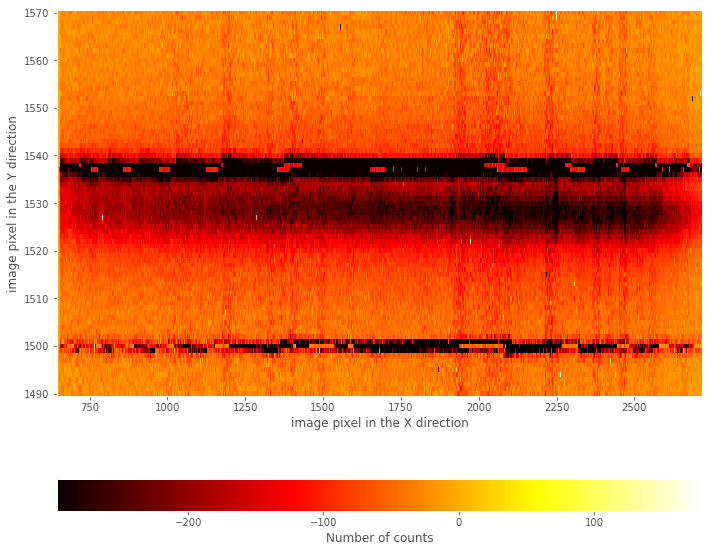

In [9]:
ximshow(image_data, image_bbox=(645,2717,1490,1570), geometry=None, debugplot=1)

In [82]:
# extract and coadd individual spectra by coadding rows
sp1 = np.sum(image_data[575:585,], axis=0)
sp2 = -np.sum(image_data[1523:1533,], axis=0)
# sum of two spectra
sp = sp1 + sp2
sp = sp / (2 * exptime)

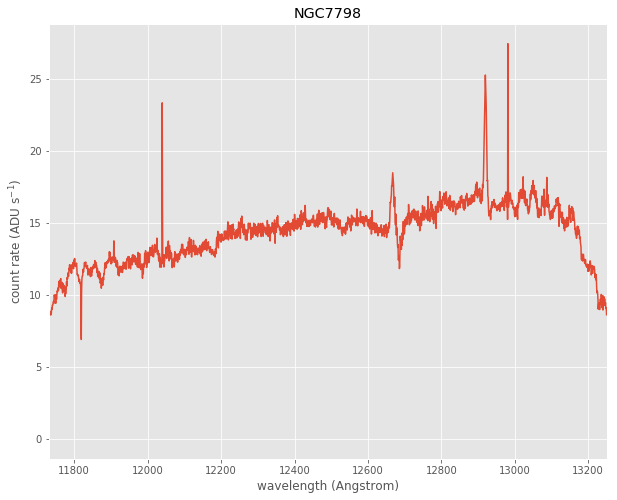

In [83]:
# plot spectrum
fig, ax = plt.subplots()
wave = crval1 + (np.arange(1, naxis1 + 1) - crpix1) * cdelt1
wvmin = 11730
wvmax = 13250
ax.plot(wave, sp)
ax.set_xlim([wvmin, wvmax])
ax.set_xlabel('wavelength (Angstrom)')
ax.set_ylabel(r'count rate (ADU s$^{-1}$)')
ax.set_title('NGC7798')

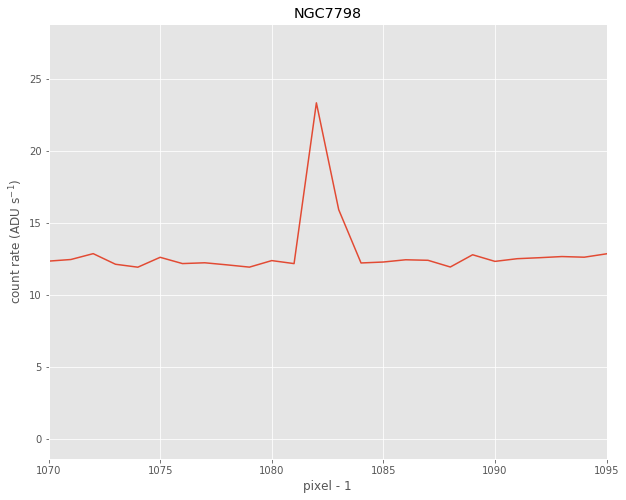

In [84]:
# plot spectrum: zoom in bad pixels
fig, ax = plt.subplots()
pixel = np.arange(naxis1)
ax.plot(pixel, sp)
ax.set_xlim([1070, 1095])
ax.set_xlabel('pixel - 1')
ax.set_ylabel(r'count rate (ADU s$^{-1}$)')
ax.set_title('NGC7798')

In [85]:
good_pixels = range(1070, 1096)
bad_pixels = 1082
good_pixels.remove(bad_pixels)
print(good_pixels)
sp[bad_pixels] = np.mean(sp[good_pixels])

[1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095]


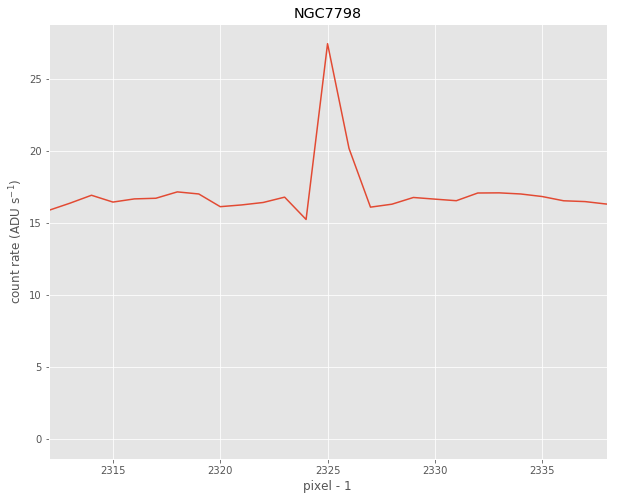

In [86]:
# plot spectrum: zoom in bad pixels
fig, ax = plt.subplots()
pixel = np.arange(naxis1)
ax.plot(pixel, sp)
ax.set_xlim([2312, 2338])
ax.set_xlabel('pixel - 1')
ax.set_ylabel(r'count rate (ADU s$^{-1}$)')
ax.set_title('NGC7798')

In [87]:
good_pixels = range(2313, 2338)
bad_pixels = [2325, 2326]
for idum in bad_pixels:
    good_pixels.remove(idum)
print(good_pixels)
sp[bad_pixels] = np.mean(sp[good_pixels])

[2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337]


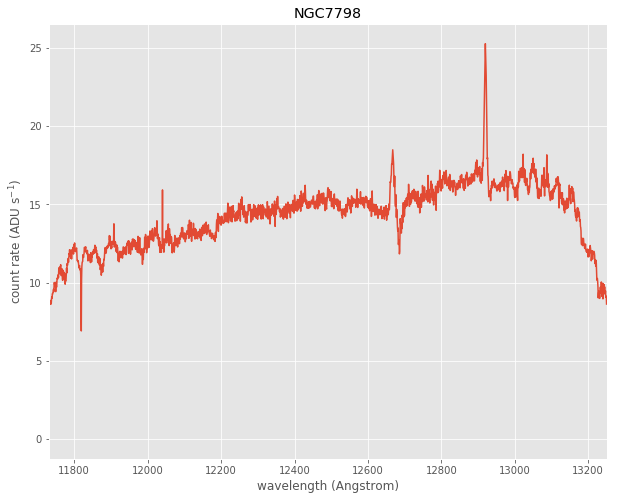

In [88]:
# plot spectrum
fig, ax = plt.subplots()
wave = crval1 + (np.arange(1, naxis1 + 1) - crpix1) * cdelt1
ax.plot(wave, sp)
ax.set_xlim([wvmin, wvmax])
ax.set_xlabel('wavelength (Angstrom)')
ax.set_ylabel(r'count rate (ADU s$^{-1}$)')
ax.set_title('NGC7798')

In [119]:
# save spectrum into FITS file
hdu_sp = fits.PrimaryHDU(data=sp, header=image_header)
hdu_sp.writeto('reduction_ngc7798/grismJ_ngc7798.fits', overwrite=True)

In [120]:
# read response curve
with fits.open('reduction_hd209290/grismJ_response_curve_hd209290.fits', 
               mode='readonly') as hdulist:
    response_header = hdulist[0].header
    response_sp = hdulist[0].data

naxis1 = response_sp.shape[0]
print('naxis1:', naxis1)

# read wavelength calibration from header
crpix1 = response_header['crpix1']
crval1 = response_header['crval1']
cdelt1 = response_header['cdelt1']
print('crpix1, crval1, cdelt1:', crpix1, crval1, cdelt1)

naxis1: 3400
crpix1, crval1, cdelt1: 1.0 11220.0 0.7575


(11730, 13250)

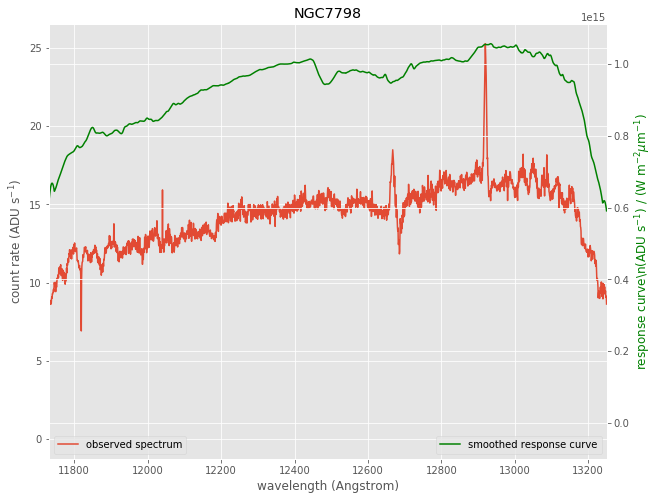

In [121]:
# plot spectrum and response curve
fig, ax = plt.subplots()
wave = crval1 + (np.arange(1, naxis1 + 1) - crpix1) * cdelt1
ax.plot(wave, sp, label='observed spectrum')
ax.set_xlabel('wavelength (Angstrom)')
ax.set_ylabel(r'count rate (ADU s$^{-1}$)')
ax.set_title('NGC7798')
ax.legend(loc=3)
ax2 = ax.twinx()
ax2.plot(wave, response_sp, 'g-', label='smoothed response curve')
ax2.set_ylabel(r'response curve\n(ADU s$^{-1}$) / (W m$^{-2} \mu\rm{m}^{-1}$)', color='g')
ax2.legend(loc=4)
ax2.set_xlim([wvmin, wvmax])

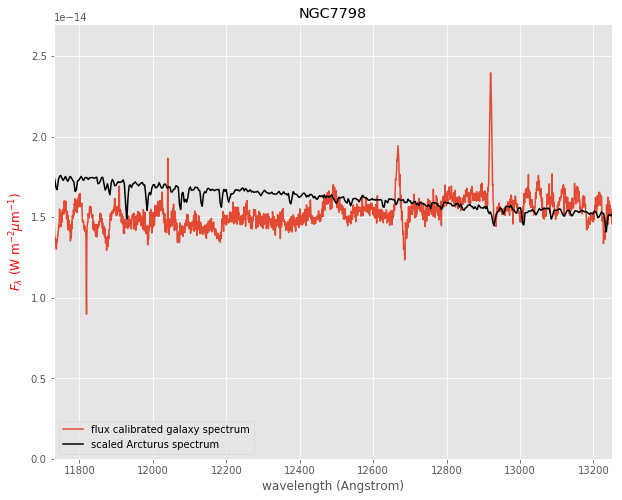

In [123]:
# to avoid division by zero, set response curve to 1.0 where it is <= 0
response_sp[np.where(response_sp <=0)] = 1.0

# flux calibration of the galaxy spectrum
yfluxed = sp / response_sp

# read Arcturus (HD124897, K1.5 III) spectrum
tab_arcturus = np.genfromtxt(
    "http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/Data/K1.5IIIFe-0.5_HD124897_lines.txt"
)
xtab = tab_arcturus[:,0] * 10000  # convert from micron to Angstrom
ytab = tab_arcturus[:,1]

# resample Arcsturus spectrum to the same sampling as the galaxy spectrum
z=z = 0.008202
from scipy.interpolate import interp1d
funinterp = interp1d(xtab*(1+z), ytab, kind="linear")
yarcturus = funinterp(wave)

# plot
fig, ax = plt.subplots()
wave = crval1 + (np.arange(1, naxis1 + 1) - crpix1) * cdelt1
ax.plot(wave, yfluxed, label='flux calibrated galaxy spectrum')
ax.set_xlabel('wavelength (Angstrom)')
ax.set_ylabel(r'$F_\lambda$ (W m$^{-2} \mu\rm{m}^{-1})$', color='r')
ax.set_title('NGC7798')
ax.plot(wave, yarcturus*7e-7, color='k', label='scaled Arcturus spectrum')
ax.set_xlim([wvmin, wvmax])
ax.set_ylim([0, 2.7e-14])
ax.legend(loc=3)